### Overview

This article follows on from the article [Portfolio Optimisation in Modern Portfolio Theory](/content/devportal/en_us/article-catalog/article/portfolio-optimization-modern-portfolio-theory). In this article we will use a recent package [mlfinlab](https://pypi.org/project/mlfinlab/) which was inspired by ideas from the top financial journals and in particular from the work of Marcos Lopez de Prado in the books [Advances in Machine Learning](https://www.wiley.com/en-gb/Advances+in+Financial+Machine+Learning-p-9781119482086) and [Machine Learning for Asset Managers](https://www.cambridge.org/core/books/machine-learning-for-asset-managers/6D9211305EA2E425D33A9F38D0AE3545). 

This article will go through how to implement some of the more classical mean-variance optimisation (MVO) solutions provided in the package and then look at a more modern approach which address some of the main criticisms of classical MVO.

**Sections**

[Getting Our Price Data](#prices)

[Returns Estimators](#rets)

[Risk Estimators - Covariance Matrix](#risk)

[Classical Mean-Variance based Weighting Schemes](#mvo)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Inverse Variance](#iv)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Maximum Sharpe](#maxsh)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Minimum Volatility](#minvol)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Efficient Risk](#effri)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Maximum Return - Minimum Volatility](#mrmv)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Efficient Return](#effre)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Efficient Return with weighting constraint](#effrewc)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Maximum Diversification](#mdiv)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Maximum Decorrelation](#mde)

[Backtesting MVO](#back)

[Heirarchical Risk Parity (HRP)](#hrp)

[Creating a Long-Short Portfolio](#ls)

[Summary](#sum)

[Further Resources](#Resources)

**Pre-requisites:**

**Refinitiv Eikon / Workspace** with access to [Eikon Data APIs](https://refini.tv/3bvPev5) (Free Trial Available)

**Python 2.x/3.x**

Required Python Packages: [eikon](https://pypi.org/project/eikon/), [pandas](https://pypi.org/project/pandas/), [numpy](https://pypi.org/project/numpy/), [matplotlib](https://pypi.org/project/matplotlib/), [mlfinlab](https://pypi.org/project/mlfinlab/)

In [1]:
import eikon as ek
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mlfinlab
from mlfinlab.portfolio_optimization.hrp import HierarchicalRiskParity
from mlfinlab.portfolio_optimization.mean_variance import MeanVarianceOptimisation
from mlfinlab.portfolio_optimization import ReturnsEstimators
from mlfinlab.portfolio_optimization import RiskEstimators
ek.set_app_key('YOUR API KEY HERE')
import warnings
warnings.filterwarnings("ignore")

<a id='prices'></a>
### Getting our Price Data

We need to work on a portfolio of assets so in Eikon or Workspace you can directly work with portfolio lists stored on your terminal and use them straight with the get_data API call. Or you could use an index for example. In our case I have made a list containing a range of instruments from different asset classes. 

In [2]:
df,err = ek.get_data('MONITOR("Portfolio List 1")','TR.RIC') #or you could use a chain RIC like '0#.FTSE'
instruments = df['RIC'].astype(str).values.tolist()

Once we have our instruments, we can then go about building our historical prices dataframe by downloading the history using the get_timeseries API call. Here we do so in iterative fashion to comply with limits per API call. 

In [3]:
start='2010-03-01'
end='2020-04-26'
ts = pd.DataFrame()
df = pd.DataFrame()

for r in instruments:
    try:
        ts = ek.get_timeseries(r,'CLOSE',start_date=start,end_date=end,interval='daily')
        ts.rename(columns = {'CLOSE': r}, inplace = True)
        if len(ts):
            df = pd.concat([df, ts], axis=1)
        else:
            df = ts
    except:
        pass
    
df

,SPY,QQQ.O,FEZ,FXI,IAU,SLV,PPLT.K,TLT.O,TIP,AAPL.O,GOOGL.O,AMZN.O,MSFT.O,HYG
Date,,,,,,,,,,,,,,
2010-03-01,111.890,45.222230,37.23,40.59,10.948,16.11,154.6500,91.34,103.92,7.463921,266.603355,124.54,29.0200,86.59
2010-03-02,112.200,45.361651,37.31,40.90,11.110,16.56,157.0000,91.22,104.00,7.458921,270.792414,125.53,28.4600,87.15
2010-03-03,112.300,45.411444,37.80,40.78,11.168,16.82,157.7500,90.99,103.96,7.476064,272.924480,125.89,28.4600,87.24
2010-03-04,112.641,45.560824,37.68,40.16,11.095,16.79,158.2100,91.47,104.07,7.525350,277.563976,128.53,28.6300,87.31
2010-03-05,114.250,46.247971,38.69,41.18,11.090,17.01,157.6200,90.27,103.84,7.819635,282.378642,128.91,28.5875,87.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,281.590,212.740000,30.30,38.09,16.230,14.26,72.6600,169.16,120.23,69.232500,1261.150000,2393.61,175.0600,79.87
2020-04-21,273.040,204.890000,29.53,37.07,16.110,13.88,70.0500,171.29,120.84,67.092500,1212.160000,2328.12,167.8200,78.41
2020-04-22,279.100,210.970000,29.86,37.97,16.400,14.09,71.6500,169.54,121.57,69.025000,1258.410000,2363.49,173.5200,79.10


Now we have our prices dataframe we need to have any NA data removed as this will lead to problems with cvxpy optimiser later. 

In [4]:
df.dropna(how='all', inplace=True)
df.drop(df.columns[df.isna().any()].tolist(),axis=1, inplace=True)

<a id='rets'></a>
### Returns Estimators

Next we need to create our returns series from our closing prices and then create the covariance matrix for those returns. The **ReturnsEstimators** class offers 3 different types of returns estimator - simple returns, annualised mean historical returns and exponentially-weighted annualized mean of historical returns. 

We will just use simple returns.

In [5]:
ret_est = ReturnsEstimators()
rets = ret_est.calculate_returns(df)
rets

,SPY,QQQ.O,FEZ,FXI,IAU,SLV,PPLT.K,TLT.O,TIP,AAPL.O,GOOGL.O,AMZN.O,MSFT.O,HYG
Date,,,,,,,,,,,,,,
2010-03-02,0.002771,0.003083,0.002149,0.007637,0.014797,0.027933,0.015196,-0.001314,0.000770,-0.000670,0.015713,0.007949,-0.019297,0.006467
2010-03-03,0.000891,0.001098,0.013133,-0.002934,0.005221,0.015700,0.004777,-0.002521,-0.000385,0.002298,0.007873,0.002868,0.000000,0.001033
2010-03-04,0.003037,0.003289,-0.003175,-0.015204,-0.006537,-0.001784,0.002916,0.005275,0.001058,0.006592,0.016999,0.020971,0.005973,0.000802
2010-03-05,0.014284,0.015082,0.026805,0.025398,-0.000451,0.013103,-0.003729,-0.013119,-0.002210,0.039106,0.017346,0.002957,-0.001484,0.005956
2010-03-08,0.000175,0.001938,0.002585,0.003400,-0.008476,-0.007055,0.013958,-0.005207,-0.000867,0.000594,-0.003066,0.009309,0.001487,0.000228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-20,-0.017618,-0.011844,-0.013029,-0.008331,0.009328,0.007774,-0.004658,0.008045,-0.003068,-0.020757,-0.013956,0.007836,-0.019821,-0.015045
2020-04-21,-0.030363,-0.036900,-0.025413,-0.026779,-0.007394,-0.026648,-0.035921,0.012592,0.005074,-0.030910,-0.038845,-0.027360,-0.041357,-0.018280
2020-04-22,0.022195,0.029674,0.011175,0.024278,0.018001,0.015130,0.022841,-0.010217,0.006041,0.028804,0.038155,0.015193,0.033965,0.008800


<a id='risk'></a>
### Risk Estimators - Covariance Matrix

A widely used representation of risk in portfolios is the covariance matrix. This measures the co-movement of assets in the portfolio. If stock A rises when stock B rises they have positive covariance, similarly if stock A falls when stock B rises they have negative covariance. Portfolio risk and volatility can be reduced by pairing assets with negative covariance. So calculating covariance is quite important. For many years simple covariance calculations were used but in more recent times critcism of this approach has emerged, arguing for instance that outliers effect the calculation and should be reduced or discarded altogether in the calculation. 

Fear not, the mlfinlab package offers a number of types of covariance calculation based on some of these criticisms.
The **RiskEstimators** class offers the following methods - minimum covariance determinant (MCD), maximum likelihood covariance estimator (Empirical Covariance), shrinked covariance, semi-covariance matrix, exponentially-weighted covariance matrix. There are also options to de-noise and de-tone covariance matricies. 

In our case we will generate a simple covariance matrix from our returns matrix using the basic pandas-provided covariance routine.

In [6]:
cov=rets.cov()
cov

,SPY,QQQ.O,FEZ,FXI,IAU,SLV,PPLT.K,TLT.O,TIP,AAPL.O,GOOGL.O,AMZN.O,MSFT.O,HYG
SPY,1.171928e-04,0.000124,0.000141,0.000118,-5.025727e-07,0.000035,0.000044,-0.000049,-7.647541e-06,0.000124,0.000119,0.000121,0.000128,4.530036e-05
QQQ.O,1.235342e-04,0.000149,0.000143,0.000127,-1.501120e-06,0.000033,0.000044,-0.000049,-7.802771e-06,0.000161,0.000150,0.000162,0.000154,4.547365e-05
FEZ,1.405077e-04,0.000143,0.000248,0.000165,8.850200e-06,0.000067,0.000072,-0.000066,-8.674920e-06,0.000133,0.000135,0.000137,0.000144,5.893346e-05
FXI,1.175224e-04,0.000127,0.000165,0.000238,9.429167e-06,0.000065,0.000065,-0.000053,-6.417078e-06,0.000124,0.000121,0.000128,0.000127,4.862888e-05
IAU,-5.025727e-07,-0.000002,0.000009,0.000009,9.842433e-05,0.000137,0.000082,0.000020,1.137075e-05,0.000002,-0.000005,-0.000005,-0.000003,3.503237e-06
SLV,3.477736e-05,0.000033,0.000067,0.000065,1.374908e-04,0.000306,0.000152,0.000006,1.398255e-05,0.000040,0.000024,0.000023,0.000030,2.033007e-05
PPLT.K,4.437408e-05,0.000044,0.000072,0.000065,8.151612e-05,0.000152,0.000171,-0.000005,7.437010e-06,0.000049,0.000038,0.000033,0.000043,2.383476e-05
TLT.O,-4.901009e-05,-0.000049,-0.000066,-0.000053,2.014332e-05,0.000006,-0.000005,0.000087,2.396091e-05,-0.000049,-0.000044,-0.000043,-0.000046,-1.543835e-05
TIP,-7.647541e-06,-0.000008,-0.000009,-0.000006,1.137075e-05,0.000014,0.000007,0.000024,1.252757e-05,-0.000008,-0.000007,-0.000006,-0.000007,-2.934690e-07
AAPL.O,1.240187e-04,0.000161,0.000133,0.000124,2.199970e-06,0.000040,0.000049,-0.000049,-8.256001e-06,0.000302,0.000148,0.000147,0.000148,4.569589e-05


We now have the minimum we need to start generating solutions of portfolio weightings for a number of objective functions. The mlfinlab library provides us with a large number of objective functions - both classical and more contemporary.
<a id='mvo'></a>
### Classical Mean-Variance based Weighting Schemes

The **MeanVarianceOptimisation** class uses quadratic optimisation - I have provided the simplest solutions here based on their documentation - but one can also add various constraints in terms of min/max weight per stock, target return, risk tolerance etc. I include an example of Efficient Return with a max weighting constraint of 0.20 (20%).

<a id='iv'></a>
**Inverse Variance**

In [7]:
mvo = MeanVarianceOptimisation()
mvo.allocate(expected_asset_returns=rets.mean(),
                     covariance_matrix=cov,
                     solution='inverse_variance') 
#additional constaints target_return=0.2, target_risk=0.01, risk_aversion=10,weight_bounds=['weights <=0.2','weights >=0']
weights = mvo.weights.sort_values(by=0, ascending=False, axis=1)
weights

,TIP,HYG,TLT.O,IAU,SPY,QQQ.O,PPLT.K,FXI,FEZ,MSFT.O,GOOGL.O,AAPL.O,SLV,AMZN.O
0,0.443641,0.17898,0.06389,0.056467,0.047424,0.037389,0.032501,0.023344,0.022428,0.022121,0.021153,0.018375,0.018163,0.014124


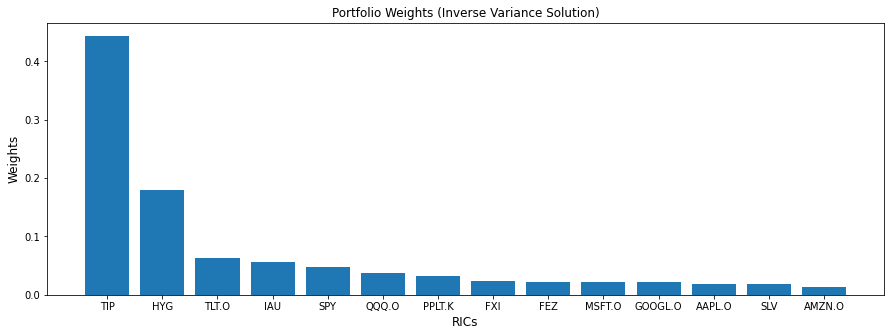

In [8]:
plt.figure(figsize=(15, 5))
plt.bar(weights.columns, weights.values[0])
plt.xlabel('RICs', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Portfolio Weights (Inverse Variance Solution)', fontsize=12)
plt.show()

<a id='maxsh'></a>
**Maximum Sharpe**

In [9]:
mvo = MeanVarianceOptimisation(calculate_expected_returns='mean', risk_free_rate=0.03)
mvo.allocate(asset_prices=df,
            covariance_matrix=cov,
            solution='max_sharpe')
weights = mvo.weights.sort_values(by=0, ascending=False, axis=1)
weights

,TLT.O,AMZN.O,AAPL.O,MSFT.O,IAU,FEZ,FXI,HYG,SPY,PPLT.K,TIP,QQQ.O,GOOGL.O,SLV
0,0.467981,0.242826,0.209082,0.078645,0.001467,1.567429e-16,1.368620e-16,1.187258e-16,8.481139e-17,7.190110e-17,5.702424e-17,5.066975e-17,4.578486e-17,0.0


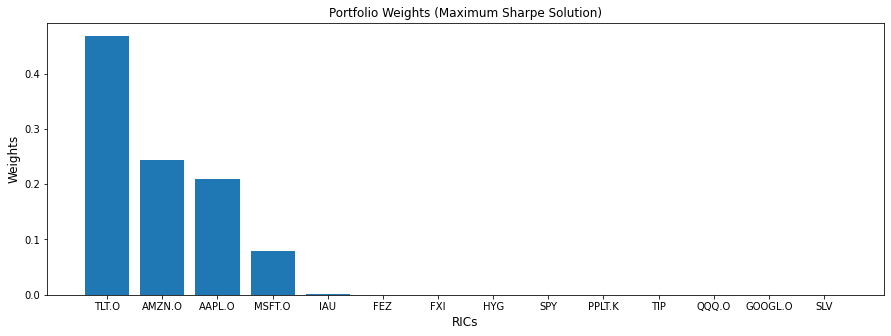

In [10]:
plt.figure(figsize=(15, 5))
plt.bar(weights.columns, weights.values[0])
plt.xlabel('RICs', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Portfolio Weights (Maximum Sharpe Solution)', fontsize=12)
plt.show()

<a id='minvol'></a>
**Minimum Volatility**

In [11]:
mvo = MeanVarianceOptimisation()
mvo.allocate(expected_asset_returns=rets.mean(),
                     covariance_matrix=cov,
                     solution='min_volatility')
weights = mvo.weights.sort_values(by=0, ascending=False, axis=1)
weights

,TIP,HYG,SPY,GOOGL.O,AAPL.O,QQQ.O,FEZ,FXI,IAU,SLV,PPLT.K,TLT.O,AMZN.O,MSFT.O
0,0.720338,0.257316,0.018083,0.003658,0.000604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


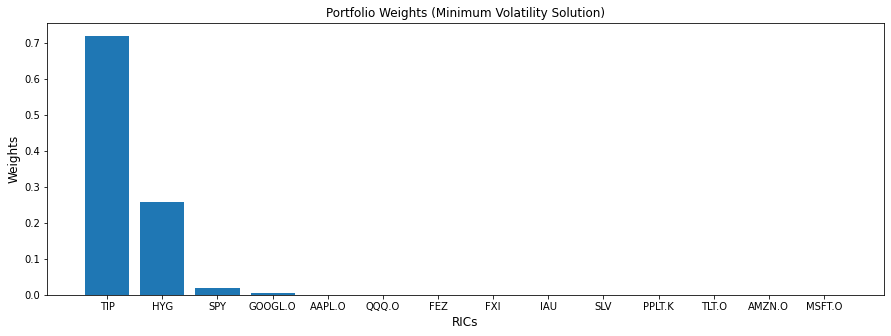

In [12]:
plt.figure(figsize=(15, 5))
plt.bar(weights.columns, weights.values[0])
plt.xlabel('RICs', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Portfolio Weights (Minimum Volatility Solution)', fontsize=12)
plt.show()

<a id='effri'></a>
**Efficient Risk**

In [13]:
mvo = MeanVarianceOptimisation()
mvo.allocate(asset_prices=df,
            covariance_matrix=cov,
            solution='efficient_risk')
weights = mvo.weights.sort_values(by=0, ascending=False, axis=1)
weights

,TLT.O,AMZN.O,AAPL.O,MSFT.O,FEZ,FXI,SPY,PPLT.K,QQQ.O,HYG,GOOGL.O,SLV,IAU,TIP
0,0.428338,0.285081,0.227616,0.058965,1.755763e-18,1.402007e-18,1.039722e-18,7.900867e-19,7.808104e-19,7.148494e-19,6.666292e-19,2.228495e-19,0.0,0.0


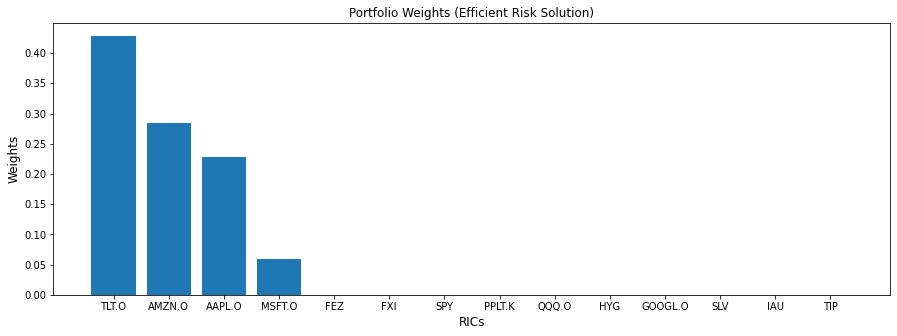

In [14]:
plt.figure(figsize=(15, 5))
plt.bar(weights.columns, weights.values[0])
plt.xlabel('RICs', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Portfolio Weights (Efficient Risk Solution)', fontsize=12)
plt.show()

<a id='mrmv'></a>
**Maximum Return - Minimum Volatility**

In [15]:
mvo = MeanVarianceOptimisation()
mvo.allocate(expected_asset_returns=rets.mean(),
                     covariance_matrix=cov,
                     solution='max_return_min_volatility')
weights = mvo.weights.sort_values(by=0, ascending=False, axis=1)
weights

,TLT.O,TIP,AMZN.O,AAPL.O,MSFT.O,IAU,SPY,GOOGL.O,QQQ.O,FXI,FEZ,SLV,PPLT.K,HYG
0,0.358932,0.194621,0.14192,0.140169,0.082781,0.074421,0.006742,0.000414,4.180929e-23,2.284883e-23,0.0,0.0,0.0,0.0


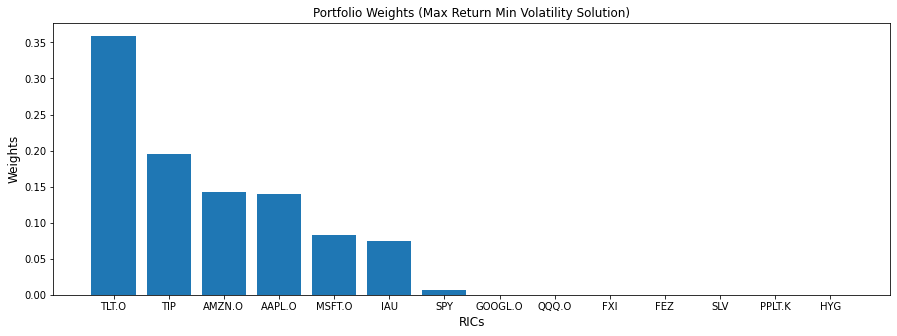

In [16]:
plt.figure(figsize=(15, 5))
plt.bar(weights.columns, weights.values[0])
plt.xlabel('RICs', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Portfolio Weights (Max Return Min Volatility Solution)', fontsize=12)
plt.show()

<a id='effre'></a>
**Efficient Return**

In [17]:
mvo = MeanVarianceOptimisation()
mvo.allocate(asset_prices=df,
            covariance_matrix=cov,
            solution='efficient_return')
weights = mvo.weights.sort_values(by=0, ascending=False, axis=1)
weights

,AMZN.O,SPY,QQQ.O,FEZ,FXI,IAU,SLV,PPLT.K,TLT.O,TIP,AAPL.O,GOOGL.O,MSFT.O,HYG
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


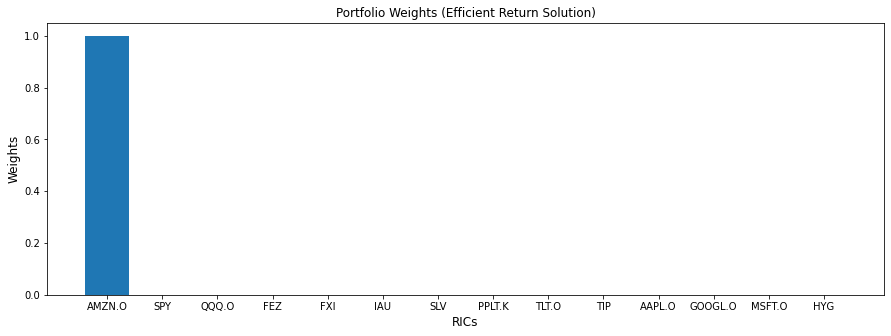

In [18]:
plt.figure(figsize=(15, 5))
plt.bar(weights.columns, weights.values[0])
plt.xlabel('RICs', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Portfolio Weights (Efficient Return Solution)', fontsize=12)
plt.show()

<a id='effrewc'></a>
**Efficient Return with weighting constraint**

In [19]:
mvo = MeanVarianceOptimisation()
mvo.allocate(asset_prices=df,
            covariance_matrix=cov,
            solution='efficient_return',
            weight_bounds =['weights <=0.2','weights >=.05'])
weights = mvo.weights.sort_values(by=0, ascending=False, axis=1)
weights

,AMZN.O,AAPL.O,MSFT.O,SPY,TLT.O,QQQ.O,IAU,TIP,SLV,FXI,HYG,FEZ,PPLT.K,GOOGL.O
0,0.2,0.2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


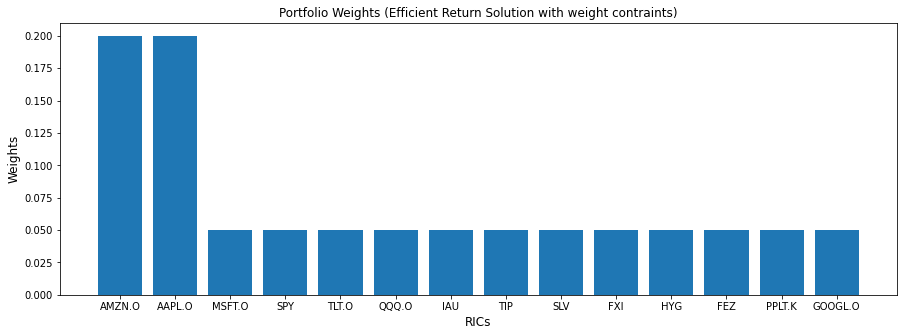

In [20]:
plt.figure(figsize=(15, 5))
plt.bar(weights.columns, weights.values[0])
plt.xlabel('RICs', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Portfolio Weights (Efficient Return Solution with weight contraints)', fontsize=12)
plt.show()

<a id='mdiv'></a>
**Maximum Diversification**

In [21]:
mvo = MeanVarianceOptimisation()
mvo.allocate(expected_asset_returns=rets.mean(),
                     covariance_matrix=cov,
                     solution='max_diversification')
weights = mvo.weights.sort_values(by=0, ascending=False, axis=1)
weights

,TLT.O,HYG,IAU,FEZ,FXI,AAPL.O,AMZN.O,MSFT.O,GOOGL.O,SLV,PPLT.K,QQQ.O,SPY,TIP
0,0.522436,0.130606,0.1002,0.066248,0.042312,0.040518,0.027041,0.024967,0.024952,0.014017,0.006704,4.927530e-23,3.114951e-23,0.0


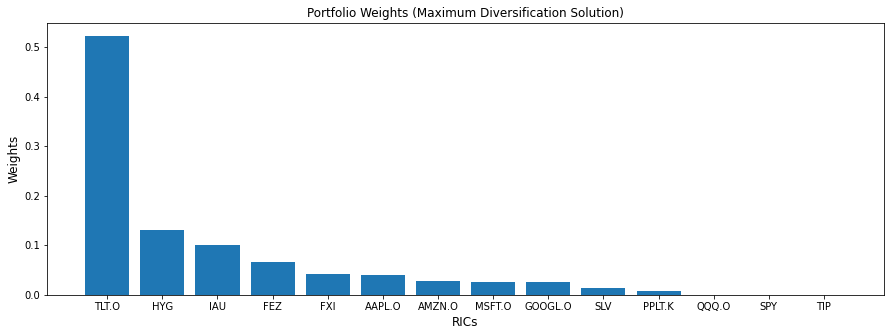

In [22]:
plt.figure(figsize=(15, 5))
plt.bar(weights.columns, weights.values[0])
plt.xlabel('RICs', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Portfolio Weights (Maximum Diversification Solution)', fontsize=12)
plt.show()

<a id='mde'></a>
**Maximum Decorrelation**

In [23]:
mvo = MeanVarianceOptimisation()
mvo.allocate(expected_asset_returns=rets.mean(),
                     covariance_matrix=cov,
                     solution='max_decorrelation')
weights = mvo.weights.sort_values(by=0, ascending=False, axis=1)
weights

,TLT.O,FEZ,AAPL.O,AMZN.O,FXI,IAU,GOOGL.O,MSFT.O,SLV,HYG,PPLT.K,QQQ.O,SPY,TIP
0,0.357804,0.12925,0.096486,0.083776,0.079312,0.077646,0.051615,0.049387,0.033769,0.03193,0.009025,5.766787e-23,2.874097e-23,0.0


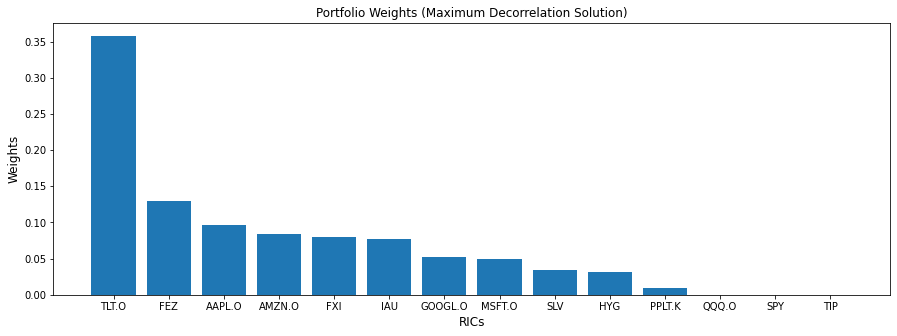

In [24]:
plt.figure(figsize=(15, 5))
plt.bar(weights.columns, weights.values[0])
plt.xlabel('RICs', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('Portfolio Weights (Maximum Decorrelation Solution)', fontsize=12)
plt.show()

<a id='back'></a>
### Backtesting MVO

Now that we have derived the portfolio weights for each scheme - we can test them against reality to see how they perform. In our case we will utilise the simple yet efficient approach to testing offered by Prof. Yves Hilpisch in his excellent new book [Artificial Intelligence in Finance](https://www.oreilly.com/library/view/artificial-intelligence-in/9781492055426/). Here we use the efficient_risk solution with a target return of 0.05 but you can substitute any of the approaches above or below. 

The basic idea is that we use 2 years of lookback data to generate the weights for year t. Each time we recalculate the returns and the covariance matrices and pass them off to the MVO routine to generate the weights for the year. We have thus a set of expected values Expected Portfolio Return (EPR), Expected Portfolio Volatility (EPV) and Expected Sharpe Ratio (ESR). We then look forward one year and generate the realised values for these Expected metrics (RPR, RPV & RSR respectively) and then compare them. 

In [25]:
ret_est = ReturnsEstimators()
y_weights = {}
res=pd.DataFrame()
for year in range(2012, 2018):
    ap = df.loc[f'{year-2}-01-01':f'{year}-12-31']
    rets = ret_est.calculate_returns(ap) 
    cov = rets.cov()
    #-------- You can replace with any scheme/solution you wish
    mvo = MeanVarianceOptimisation()
    mvo.allocate(asset_prices=ap, covariance_matrix=cov, target_return = 0.05,solution='efficient_risk')
    y_weights[year] = np.array(mvo.weights).flatten()
    #-------------------------------------------------
    epr = np.dot(rets.mean(), y_weights[year].T) * 252 
    epv = np.dot(y_weights[year].T, np.dot(rets.cov() * 252, y_weights[year].T)) ** 0.5 
    esr = epr/epv 
    ap1 = df.loc[f'{year + 1}-01-01':f'{year + 1}-12-31']
    rets1 = ret_est.calculate_returns(ap1)
    rpv = np.dot(y_weights[year].T, np.dot(rets1.cov() * 252, y_weights[year].T)) ** 0.5
    rpr = np.dot(rets1.mean(), y_weights[year].T) * 252
    rsr = rpr / rpv
    res = res.append(pd.DataFrame({'epv': epv, 'epr': epr, 'esr': esr,'rpv': rpv, 'rpr': rpr, 'rsr': rsr},index=[year + 1]))

display(res, pd.DataFrame(res.mean()))

,epv,epr,esr,rpv,rpr,rsr
2013,0.045617,0.052022,1.140408,0.053196,-0.060865,-1.144162
2014,0.050667,0.050000,0.986832,0.038074,0.050444,1.324886
2015,0.046042,0.050000,1.085962,0.058668,-0.013958,-0.237909
2016,0.058680,0.050000,0.852079,0.060682,0.054002,0.889927
2017,0.053076,0.050000,0.942041,0.038367,0.087228,2.273491
2018,0.046049,0.050000,1.085797,0.047726,-0.020477,-0.429049


,0
epv,0.050022
epr,0.050337
esr,1.015520
rpv,0.049452
rpr,0.016063
rsr,0.446198


We can see from the aggregate picture that realised volatility was roughly inline with what was expected, however both returns and sharpe ratio were less than half that expected. Further inspecting the annualised picture we can see very marked differences in both realised return and sharpe ratio. The fact that over half of the investable universe was zero weighted also would lead to concerns in using such a weighting scheme in real life though one could mitigate this by imposing minimum weighting constraints. 

So there has been a fair bit of criticism of these approaches. In his [2016 paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678) Lopez de Prado addresses some of these weakenesses with an approach called Heirachical Risk Parity.

<a id='hrp'></a>
### Heirarchical Risk Parity (HRP)

This approach uses a heirarchcal tree clustering algorithm to cluster stocks with similar performance attributes. Then a matrix seriation is applied which rearranges the covariance matrix and clusters instruments with similar characteristics. Finally, a recursive bisection process allocates the weights. HRP is supposed to give more stable results compared to classical MVO as the allocation process operates intra-cluster as opposed to across all instruments - in this sense it should achieve a broader representation. 

In [26]:
hrp = HierarchicalRiskParity()
hrp.allocate(asset_names=df.columns, asset_prices=df)
hrp_weights = hrp.weights.sort_values(by=0, ascending=False, axis=1)
hrp_weights

,TIP,HYG,TLT.O,IAU,QQQ.O,FXI,PPLT.K,SPY,AMZN.O,GOOGL.O,MSFT.O,AAPL.O,FEZ,SLV
0,0.567505,0.162762,0.079136,0.025782,0.022463,0.021228,0.019526,0.018768,0.018067,0.017178,0.015494,0.014922,0.008876,0.008293


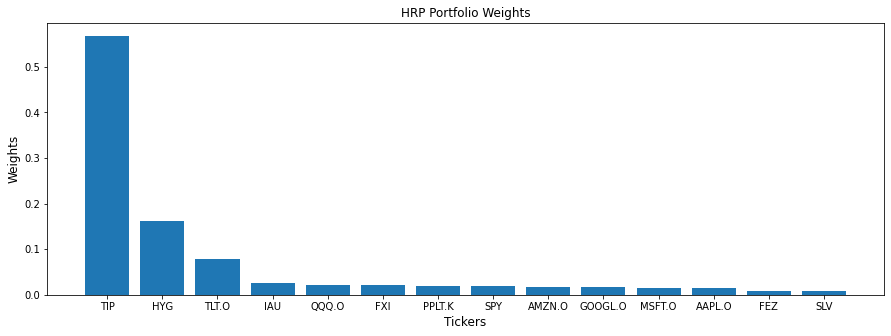

In [27]:
plt.figure(figsize=(15, 5))
plt.bar(hrp_weights.columns, hrp_weights.values[0])
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('HRP Portfolio Weights', fontsize=12)
plt.show()

So lets see how this performs out-of-sample over our horizon. We use the same routine as before simply replacing the the MVO class solution with the HRP class solution.

In [28]:
ret_est = ReturnsEstimators()
y_weights = {}
res=pd.DataFrame()
for year in range(2012, 2018):
    ap = df.loc[f'{year-2}-01-01':f'{year}-12-31']
    rets = ret_est.calculate_returns(ap) 
    cov = rets.cov()
    #-------- You can replace with any scheme/solution you wish
    hrp = HierarchicalRiskParity()
    hrp.allocate(asset_names=df.columns, asset_prices=df)
    y_weights[year] = np.array(hrp.weights).flatten()
    #-------------------------------------------------
    epr = np.dot(rets.mean(), y_weights[year].T) * 252 
    epv = np.dot(y_weights[year].T, np.dot(rets.cov() * 252, y_weights[year].T)) ** 0.5 
    esr = epr/epv 
    ap1 = df.loc[f'{year + 1}-01-01':f'{year + 1}-12-31']
    rets1 = ret_est.calculate_returns(ap1)
    rpv = np.dot(y_weights[year].T, np.dot(rets1.cov() * 252, y_weights[year].T)) ** 0.5
    rpr = np.dot(rets1.mean(), y_weights[year].T) * 252
    rsr = rpr / rpv
    res = res.append(pd.DataFrame({'epv': epv, 'epr': epr, 'esr': esr,'rpv': rpv, 'rpr': rpr, 'rsr': rsr},index=[year + 1]))

display(res, pd.DataFrame(res.mean()))

,epv,epr,esr,rpv,rpr,rsr
2013,0.159534,0.141167,0.884872,0.107453,0.144666,1.346322
2014,0.145685,0.120309,0.825815,0.103744,0.115993,1.118060
2015,0.113704,0.136202,1.197866,0.140061,0.059406,0.424146
2016,0.117947,0.105011,0.890327,0.117445,0.091304,0.777416
2017,0.121306,0.083813,0.690923,0.077025,0.230472,2.992158
2018,0.114753,0.125024,1.089506,0.173468,-0.011529,-0.066464


,0
epv,0.128821
epr,0.118588
esr,0.929885
rpv,0.119866
rpr,0.105052
rsr,1.098606


Here we can see from the mean results that the HRP weighted portfolio realised metrics performed much closer to the expected. However looking at the annualized picture still shows significant differences - though much less than the MVO class we tested earlier. 

<a id='ls'></a>
### Creating a Long-Short Portfolio

The mlfinlab library allows for shorting of instruments via the side_weights parameter. In this case we just say that the first 4 assets can be shorted by attaching a side weight of -1 and passing these side weights to the allocate method. 

In [29]:
hrp = HierarchicalRiskParity()
side_weights = pd.Series([1]*df.shape[1], index=df.columns)
side_weights.loc[df.columns[:4]] = -1
hrp.allocate(asset_prices=df, asset_names=df.columns, side_weights=side_weights)
hrp_weights = hrp.weights.sort_values(by=0, ascending=False, axis=1)
hrp_weights

,TIP,HYG,TLT.O,IAU,PPLT.K,AMZN.O,GOOGL.O,MSFT.O,AAPL.O,SLV,FEZ,SPY,FXI,QQQ.O
0,0.305549,0.087632,0.042607,0.013881,0.010513,0.009728,0.009249,0.008342,0.008034,0.004465,-0.062212,-0.131547,-0.148795,-0.157446


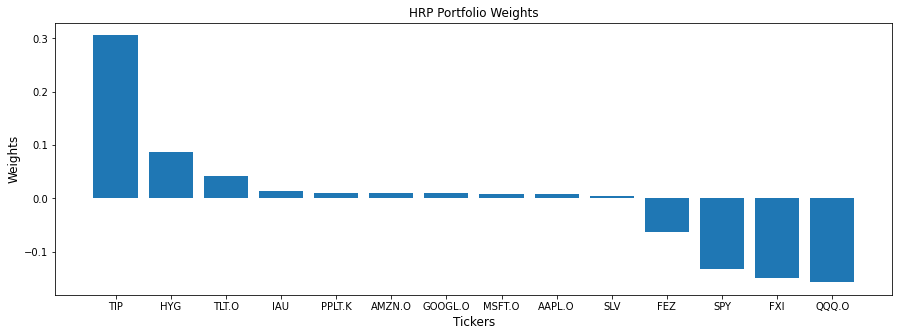

In [30]:
plt.figure(figsize=(15, 5))
plt.bar(hrp_weights.columns, hrp_weights.values[0])
plt.xlabel('Tickers', fontsize=12)
plt.ylabel('Weights', fontsize=12)
plt.title('HRP Portfolio Weights', fontsize=12)
plt.show()

<a id='sum'></a>
### Summary

In this article we have highlighted a recent package called mlfinlab which offers a really broad and rapidly expanding toolkit for the financial practitioner. We showed how you can call your portfolios and lists in Eikon / Workspace directly with the get_data API function. We then showed how to generate measures of returns using the **ReturnsEstimator** class and risks using the **RiskEstimator** class. We touched on the importance of the covariance matrix and some of the criticisms surrounding its calculation. We then looked at the **MeanVarianceOptimisation** class and generated weightings solutions for a number of different objective functions. 

We then created a routine so we could test how these schemes performed using 2 years worth of lookback data out-of-sample for 6 years and noted some of the criticisms of MVO based on our empirical evidence. In response we looked at the **HeirarchicalRiskParity** class which tries to solve for some of the shortcomings of MVO - and found some evidence for this. Finally, we looked at how we could construct a long-short portfolio using the side weights parameter. 

The whole portfolio construction and optimisation space seems to be receiving a lot of attention in recent years as evidenced by the number of papers and an interest in applying more data-driven approaches. I hope to have provided a little insight into how one can start to use these new tools to explore further.  

<a id='Resources'></a>
**Further Resources for Eikon Data API**

* [Overview](https://developers.refinitiv.com/eikon-data-apis) 
* [Quick Start ](https://developers.refinitiv.com/eikon-data-apis/quick-start)
* [Documentation](https://developers.refinitiv.com/eikon-data-apis/docs)
* [Downloads](https://developers.refinitiv.com/eikon-data-apis/downloads)
* [Tutorials](https://developers.refinitiv.com/eikon-data-apis/learning)
* [Q&A Forums](https://developers.refinitiv.com/eikon-data-apis/qa)

For Content Navigation in Eikon - please use the Data Item Browser Application: Type 'DIB' into Eikon Search Bar.
